# Assignment 1: Anomaly detection through LSTM

In [29]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

## Dataset description (columns name and correspondent descriptions):
1. **Time**: Time of measurement, given in following format: yyyy-mm-dd HH:MM:SS.
2. **Tp**: The temperature of the water, given in °C.
3. **Cl**: Amount of chlorine dioxide in the water, given in mg/L (MS1).
4. **pH**: PH value of the water.
5. **Redox**: Redox potential, given in mV.
6. **Leit**: Electric conductivity of the water, given in µS/cm.
7. **Trueb**: Turbidity of the water, given in NTU.
8. **Cl_2**: Amount of chlorine dioxide in the water, given in mg/L ($MS_2$).
9. **Fm**: Flow rate at water line 1, given in $m^3$/h.
10. **Fm_2**: Flow rate at water line 2, given in $m^3$/h.
11. **EVENT**: Marker if this entry should be considered as a remarkable change resp. event, given in boolean.

Note1: Data goes **from August 2016 to November 2016**.

Note2: The column EVENT contains the changes registered in water quality. These changes will be detected using LSTM architecture, and the column EVENT will be used at the end for a final check.

## Loading of the dataset

In [30]:
#File path
path = r"C:\Users\sofyc\OneDrive\Desktop\UPEC\ML II\project LSTM\ResourcePackage2018\ResourcePackage\source\R\Framework\Data\waterDataTraining.RDS"

#Loading
data = pyreadr.read_r(path) #dictionary

data

OrderedDict([(None,
                                    Time    Tp    Cl    pH  Redox   Leit  Trueb   Cl_2  \
              0      2016-08-03 09:49:00   6.5  0.17  8.36  749.0  211.0  0.011  0.118   
              1      2016-08-03 09:50:00   6.5  0.17  8.36  749.0  211.0  0.011  0.118   
              2      2016-08-03 09:51:00   6.5  0.17  8.35  749.0  211.0  0.011  0.117   
              3      2016-08-03 09:52:00   6.5  0.17  8.35  749.0  211.0  0.011  0.118   
              4      2016-08-03 09:53:00   6.5  0.17  8.35  749.0  211.0  0.011  0.118   
              ...                    ...   ...   ...   ...    ...    ...    ...    ...   
              139561 2016-11-08 07:50:00  10.1  0.16  8.41  762.0  189.0  0.023  0.105   
              139562 2016-11-08 07:51:00  10.1  0.17  8.41  762.0  190.0  0.022  0.106   
              139563 2016-11-08 07:52:00  10.1  0.17  8.41  762.0  190.0  0.022  0.106   
              139564 2016-11-08 07:53:00  10.1  0.17  8.41  762.0  190.0  0.022 

In [31]:
#Extracting the object from the dictionary data
df = data[None]  #RDS file format usually saves a single anonimous object

#Take a look
df

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03 09:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2016-08-03 09:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,2016-08-03 09:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,2016-08-03 09:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,2016-08-03 09:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False
...,...,...,...,...,...,...,...,...,...,...,...
139561,2016-11-08 07:50:00,10.1,0.16,8.41,762.0,189.0,0.023,0.105,1799.0,924.0,False
139562,2016-11-08 07:51:00,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1835.0,927.0,False
139563,2016-11-08 07:52:00,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1807.0,924.0,False
139564,2016-11-08 07:53:00,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1799.0,930.0,False


## Exploratory data analysis
- ##### Descriptive Statistics for each interested variable.

In [80]:
#Columns names
columns = ['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']

for i in columns:
    display(pd.DataFrame(df[i].describe()).transpose())

,count,mean,std,min,25%,50%,75%,max
Tp,138522.0,8.521406,1.281314,0.0,7.5,8.4,9.5,11.8


,count,mean,std,min,25%,50%,75%,max
Cl,138521.0,0.165482,0.010207,0.0,0.16,0.17,0.17,0.8


,count,mean,std,min,25%,50%,75%,max
pH,138522.0,8.366416,0.101624,4.0,8.34,8.37,8.39,8.936228


,count,mean,std,min,25%,50%,75%,max
Redox,138522.0,752.899009,12.945284,300.0,751.0,754.0,756.0,895.0


,count,mean,std,min,25%,50%,75%,max
Leit,138522.0,209.520998,7.747497,0.0,209.0,211.0,211.0,646.0


,count,mean,std,min,25%,50%,75%,max
Trueb,138522.0,0.019778,0.005492,0.0,0.016,0.018,0.023,0.254


,count,mean,std,min,25%,50%,75%,max
Cl_2,138522.0,0.106099,0.007132,0.0,0.103,0.106,0.11,0.462


,count,mean,std,min,25%,50%,75%,max
Fm,138522.0,1534.208891,208.171011,0.0,1388.0,1512.0,1650.0,3923.0


,count,mean,std,min,25%,50%,75%,max
Fm_2,138522.0,927.728014,147.44743,0.0,847.0,925.0,1000.0,2592.0


- ##### Time series plot for each variable. 'Time' and 'EVENT' are excluded. Anomalies from the column 'EVENT' are signed by red points.

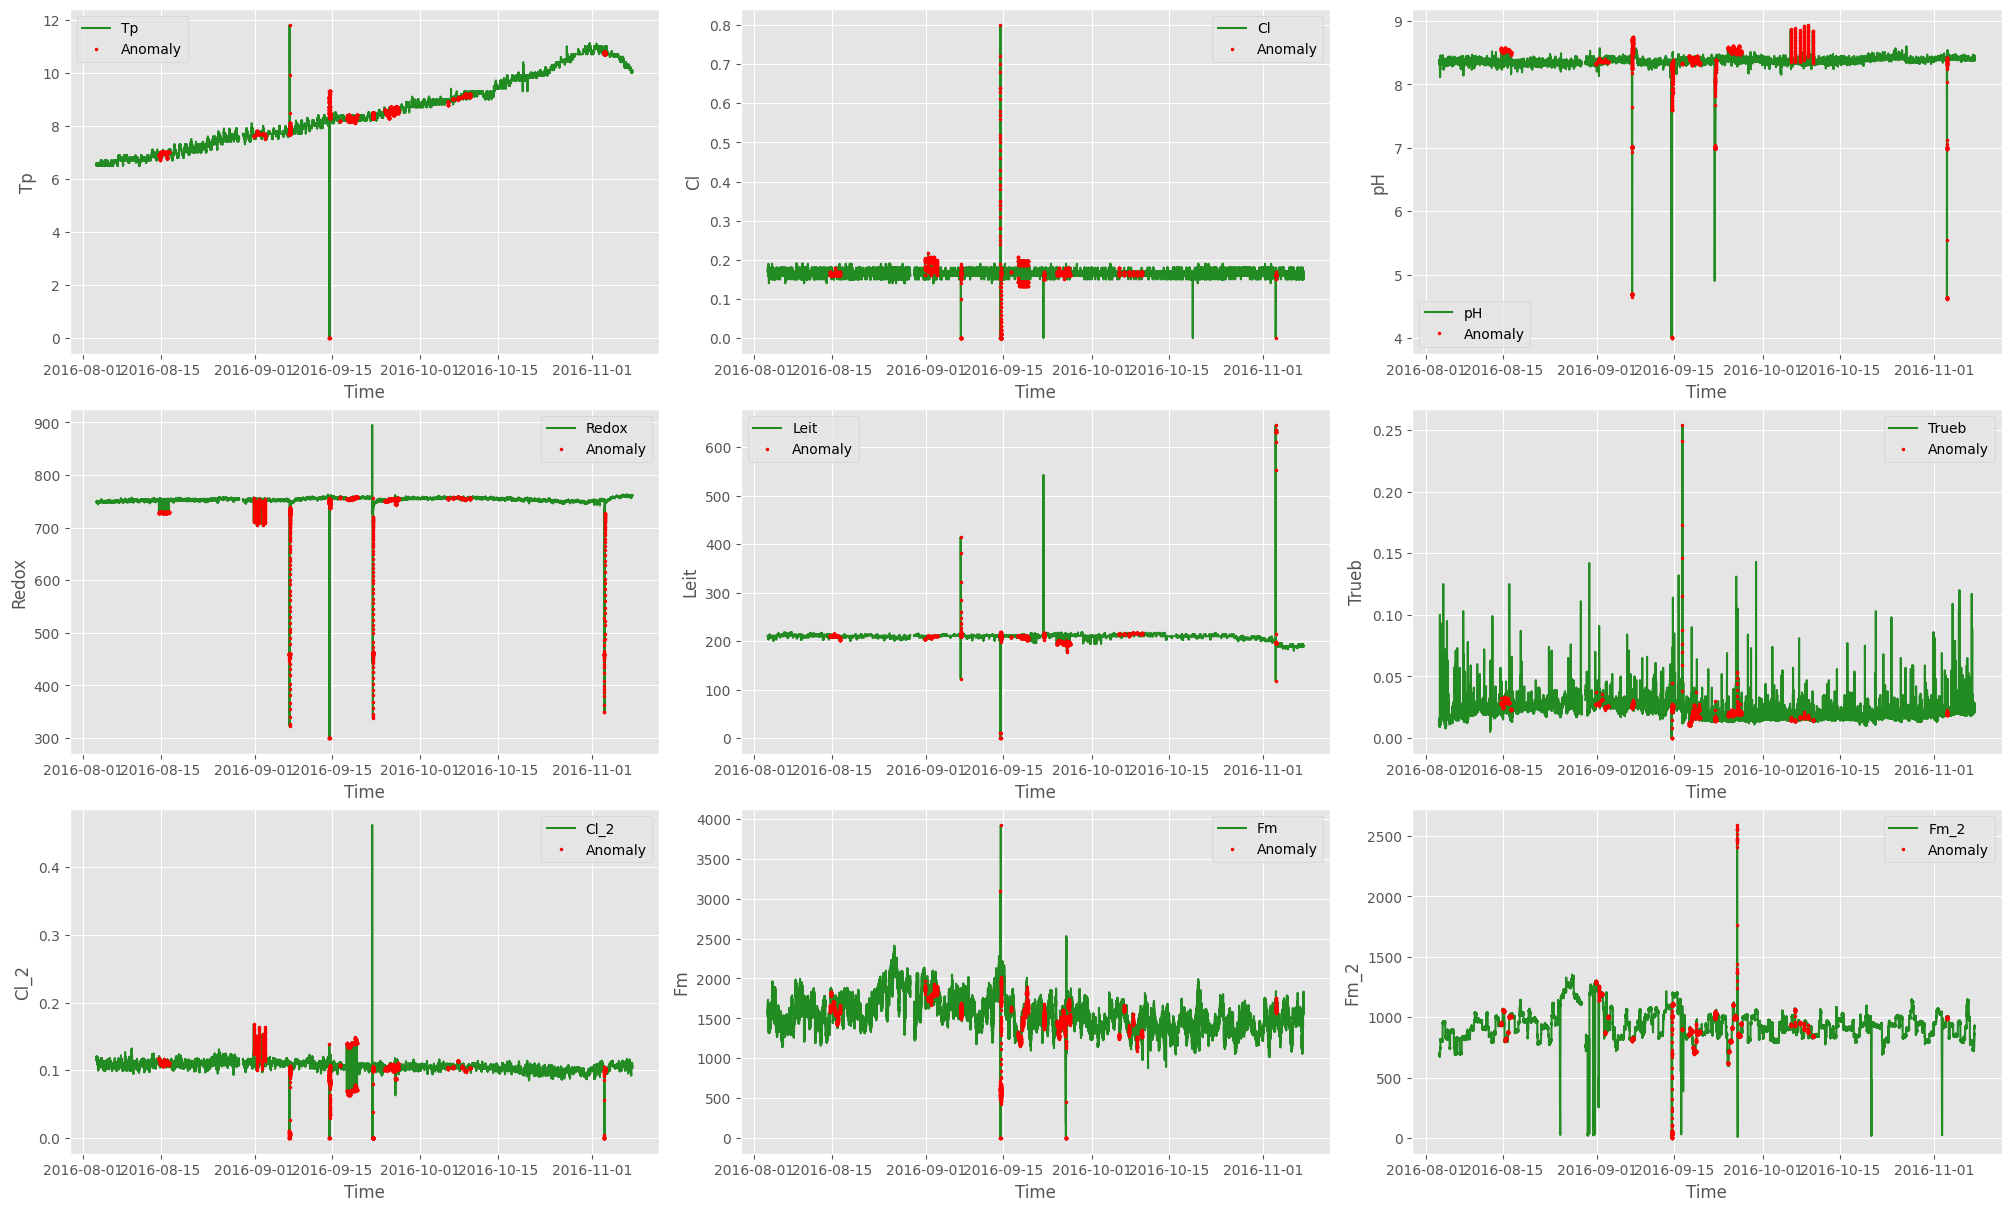

In [81]:
#Number of subplots excluding 'Time'
num_cols = len(columns) - 1
rows = (num_cols + 2) // 3  #3 subplots per row

fig, axes = plt.subplots(rows, 3, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    
    #Time series of the specific variable
    ax.plot(df['Time'], df[col], label=col, color='forestgreen')
    
    #Anomalies where 'EVENT'=True
    anomaly_mask = df['EVENT'] == True
    ax.plot(df['Time'][anomaly_mask], df[col][anomaly_mask], '.', label='Anomaly', color='red', markersize=3)
    
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.grid(True)
    ax.legend()
plt.show()


- ##### Seasonality plots.

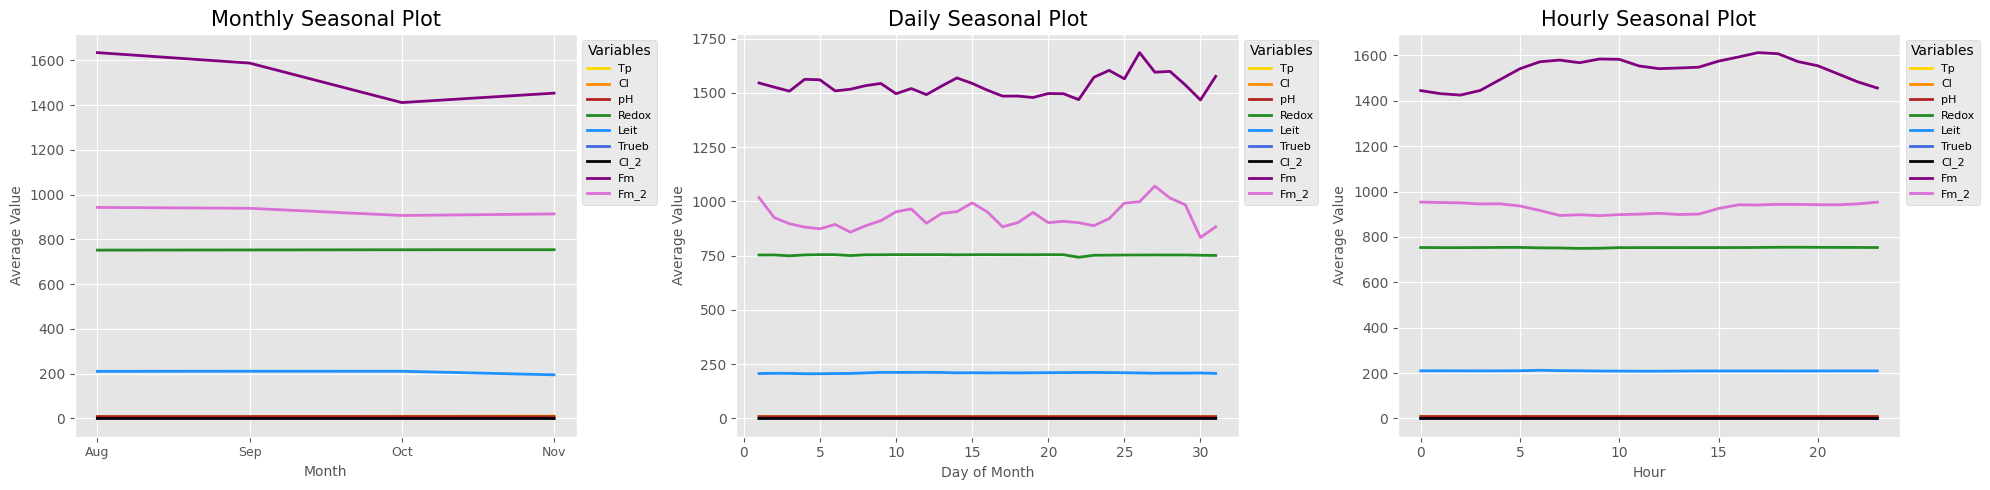

In [34]:
#Just an initial checkl for the datetime format
df['Time'] = pd.to_datetime(df['Time'])

#Extracting the year, month, the day and the hour.
df.loc[:, 'year'] = df['Time'].dt.year
df.loc[:, 'month'] = df['Time'].dt.month
df.loc[:, 'day'] = df['Time'].dt.day
df.loc[:, 'hour'] = df['Time'].dt.hour

#Columns to plot
columns = ['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']

#Groupifying data by month
df_plot_monthly = (
    df.groupby(['month'])[columns].mean()
    .reset_index()
    .sort_values(by='month')
)

#Groupifying data by day
df.loc[:, 'day_of_month'] = df['Time'].dt.day
df_plot_daily = (
    df.groupby(['day_of_month'])[columns].mean()
    .reset_index()
    .sort_values(by='day_of_month')
)

#Groupifying data by hour
df_plot_hourly = (
    df.groupby(['hour'])[columns].mean()
    .reset_index()
    .sort_values(by='hour')
)

#Plot settings
color = ['gold', 'darkorange', 'firebrick', 'forestgreen', 'dodgerblue', 
         'royalblue', 'black', 'purple', 'orchid'] #Colors
plt.style.use('ggplot') #Style

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

#Plot for monthly seasonality
for i, col in enumerate(columns):
    axes[0].plot(df_plot_monthly['month'], df_plot_monthly[col], 
                 label=col, color=color[i], linewidth=2)
axes[0].set_title('Monthly Seasonal Plot', fontsize=15)
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('Average Value', fontsize=10)
axes[0].set_xticks([8, 9, 10, 11])
axes[0].set_xticklabels(['Aug', 'Sep', 'Oct', 'Nov'], fontsize=9)
axes[0].legend(title='Variables', fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

#Plot for daily seasonality
for i, col in enumerate(columns):
    axes[1].plot(df_plot_daily['day_of_month'], df_plot_daily[col], 
                 label=col, color=color[i], linewidth=2)
axes[1].set_title('Daily Seasonal Plot', fontsize=15)
axes[1].set_xlabel('Day of Month', fontsize=10)
axes[1].set_ylabel('Average Value', fontsize=10)
axes[1].legend(title='Variables', fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

#Plot for hourly seasonality
for i, col in enumerate(columns):
    axes[2].plot(df_plot_hourly['hour'], df_plot_hourly[col], 
                 label=col, color=color[i], linewidth=2)
axes[2].set_title('Hourly Seasonal Plot', fontsize=15)
axes[2].set_xlabel('Hour', fontsize=10)
axes[2].set_ylabel('Average Value', fontsize=10)
axes[2].legend(title='Variables', fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## LSTM architecture
```mermaid
graph LR
    A[Input Data] --> B["LSTM (64, return_sequences=True)"]
    B --> C["LSTM (32, return_sequences=False)"]
    C --> D[RepeatVector]
    D --> E["LSTM (32, return_sequences=True)"]
    E --> F["LSTM (64, return_sequences=True)"]
    F --> G["Output (TimeDistributed Dense)"]

    %% Styling
    style A fill:#A8D5BA,stroke:#000,stroke-width:2px, color:#000
    style B fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style C fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style D fill:#F6A6B2,stroke:#000,stroke-width:2px, color:#000
    style E fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style F fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style G fill:#A8D5BA,stroke:#000,stroke-width:2px, color:#000
```

- ##### Before applying LSTM autoencoder alogirthm, we need to look at the NAs values and substitute them in case there are:

In [35]:
#Verifying if there are missing values
print(df.isna().sum())

Time               0
Tp              1044
Cl              1045
pH              1044
Redox           1044
Leit            1044
Trueb           1044
Cl_2            1044
Fm              1044
Fm_2            1044
EVENT              0
year               0
month              0
day                0
hour               0
day_of_month       0
dtype: int64


In [36]:
#Filling missing values with the column mean
data_cleaned = df.fillna(df.mean())

#Verifying if missing values are handled
print(data_cleaned.isna().sum())  #Should print all zeros

Time            0
Tp              0
Cl              0
pH              0
Redox           0
Leit            0
Trueb           0
Cl_2            0
Fm              0
Fm_2            0
EVENT           0
year            0
month           0
day             0
hour            0
day_of_month    0
dtype: int64


- ##### Now we look at the registrations for each timestamp.

In [37]:
print(data_cleaned['Time'])
#Data are registered each minute

0        2016-08-03 09:49:00
1        2016-08-03 09:50:00
2        2016-08-03 09:51:00
3        2016-08-03 09:52:00
4        2016-08-03 09:53:00
                 ...        
139561   2016-11-08 07:50:00
139562   2016-11-08 07:51:00
139563   2016-11-08 07:52:00
139564   2016-11-08 07:53:00
139565   2016-11-08 07:54:00
Name: Time, Length: 139566, dtype: datetime64[ns]


- ##### We look also at the column EVENT that will not be in our model, but is useful in order to have an idea of how many anomalies we should find.

In [41]:
#Number of anomalies registered
sum(data_cleaned['EVENT']==True)

1726

- ##### Normalization of the data taking into account just the following columns needed for the model: 'Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2'.

In [43]:
#Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
data_cleaned = data_cleaned[columns]
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=columns)

#Check normalized data
print(data_normalized.head())

         Tp      Cl        pH     Redox      Leit     Trueb      Cl_2  \
0  0.550847  0.2125  0.883266  0.754622  0.326625  0.043307  0.255411   
1  0.550847  0.2125  0.883266  0.754622  0.326625  0.043307  0.255411   
2  0.550847  0.2125  0.881240  0.754622  0.326625  0.043307  0.253247   
3  0.550847  0.2125  0.881240  0.754622  0.326625  0.043307  0.255411   
4  0.550847  0.2125  0.881240  0.754622  0.326625  0.043307  0.255411   

         Fm      Fm_2  
0  0.427479  0.268133  
1  0.397910  0.268519  
2  0.403008  0.268519  
3  0.402498  0.267361  
4  0.399439  0.265818  


- ##### Now we create Time-Series sequences.

In [44]:
#Function to create time-series sequences
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps + 1):
        seq = data.iloc[i : i + timesteps].values
        sequences.append(seq)
    return np.array(sequences)

#Setting time steps
timesteps = 30

#Creating sequences
input_data = create_sequences(data_normalized, timesteps)
print(f"Input shape: {input_data.shape}")  #Example: (num_samples, timesteps, num_features)

Input shape: (139537, 30, 9)


- ##### Splitting the data into Training and Validation sets.

In [ ]:
#Splitting the data into training and validation sets
X_train, X_val = train_test_split(input_data, test_size=0.2, random_state=42)
print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}")

Training shape: (111629, 30, 9), Validation shape: (27908, 30, 9)


- ##### Building and compiling the LSTM Autoencoder.

In [58]:
#Define the LSTM Autoencoder
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, input_data.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(input_data.shape[2]))
])

#Compile the model with a low learning rate and gradient clipping
model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mse') #SARKER LEARNING RATE 0.0001
model.summary()

c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 9)          │           585 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,097 (254.29 KB)

 Trainable params: 65,097 (254.29 KB)

 Non-trainable params: 0 (0.00 B)

- ##### Training and application of the model.

In [59]:
#Train the model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    shuffle=True
)

Epoch 1/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 117s 63ms/step - loss: 0.0162 - val_loss: 1.9069e-04
Epoch 2/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 104s 59ms/step - loss: 2.1428e-04 - val_loss: 1.5684e-04
Epoch 3/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 109s 63ms/step - loss: 1.6886e-04 - val_loss: 1.5873e-04
Epoch 4/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 95s 55ms/step - loss: 1.4944e-04 - val_loss: 1.3075e-04
Epoch 5/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - loss: 1.4320e-04 - val_loss: 1.1579e-04
Epoch 6/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - loss: 1.2285e-04 - val_loss: 1.0713e-04
Epoch 7/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - loss: 1.0762e-04 - val_loss: 9.8216e-05
Epoch 8/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 109s 62ms/step - loss: 1.0611e-04 - val_loss: 8.8274e-05
Epoch 9/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - loss: 1.1172e-04 - val_loss: 1.0263e-04
Epoch 10/50
1745/1745 ━━━━━━━━━━━━━━━━━━━━ 93s 53ms/step - loss: 1.2556e-04 - val_loss: 9.0981e-05
Epoch 11/50
1745/1

- ##### Plot of the Loss Curve.

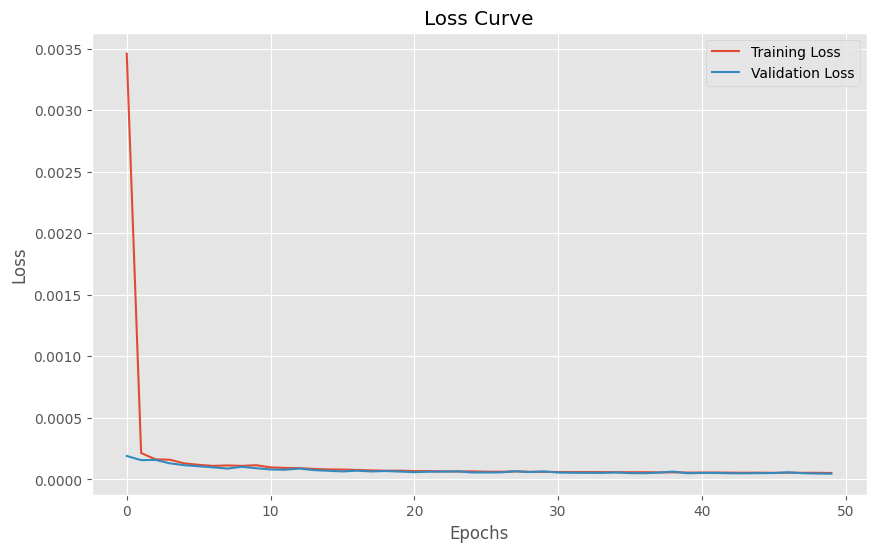

In [66]:
#Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- ##### Evaluation of the reconstruction errors.

In [61]:
#Prediction on validation data
reconstructed = model.predict(X_val)

#Calculating the reconstruction error
reconstruction_error = np.mean(np.power(X_val - reconstructed, 2), axis=(1, 2))
print(f"Reconstruction error shape: {reconstruction_error.shape}")

873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
Reconstruction error shape: (27908,)


- ##### Define Anomaly Threshold:

In [62]:
#Defining threshold (95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

#Identifying anomalies
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

Anomaly detection threshold: 7.79441029616323e-05
Number of anomalies detected: 1396


- ##### Visualization of reconstruction errors.

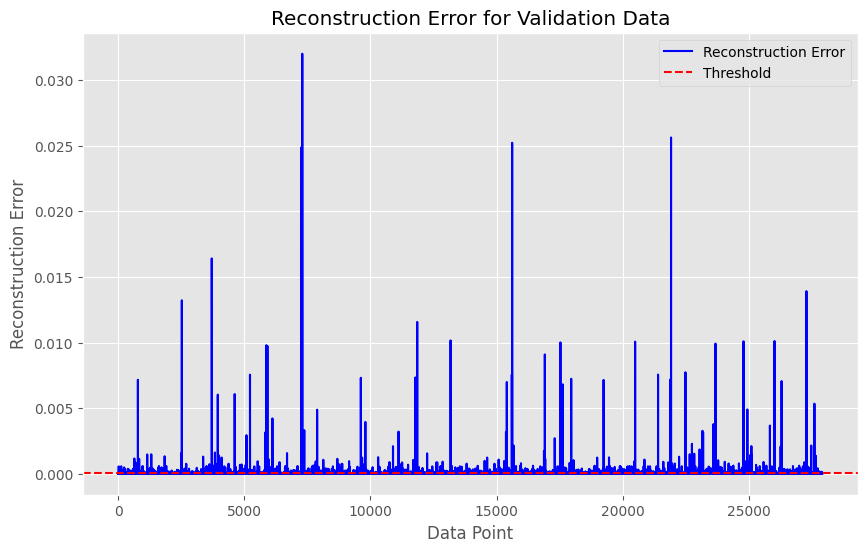

In [68]:
#Plot reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error', color='blue')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error for Validation Data")
plt.xlabel("Data Point")
plt.ylabel("Reconstruction Error")
plt.show()

- ##### Examples of Well-Predicted and Poorly-Predicted data.

In [74]:
#Example of well-predicted data
well_predicted_index = np.argmin(reconstruction_error)
print(f"Well-predicted data point (index {well_predicted_index}):")
print(f"Original: {X_val[well_predicted_index]}")
print(f"Reconstructed: {reconstructed[well_predicted_index]}")

Well-predicted data point (index 2280):
Original: [[0.59322034 0.2        0.87718807 0.76302521 0.32662539 0.1023622
  0.23593074 0.35100688 0.375     ]
 [0.59322034 0.2        0.87718807 0.76302521 0.32662539 0.1023622
  0.23809524 0.35737956 0.37114198]
 [0.59322034 0.2        0.87718807 0.75966387 0.32662539 0.1023622
  0.23376623 0.34871272 0.37307099]
 [0.59322034 0.2        0.87718807 0.76302521 0.32662539 0.1023622
  0.23593074 0.35508539 0.3746142 ]
 [0.59322034 0.2        0.87718807 0.76134454 0.32662539 0.1023622
  0.23593074 0.34998725 0.37075617]
 [0.59322034 0.2        0.87921391 0.75966387 0.32662539 0.1023622
  0.23593074 0.35457558 0.37654321]
 [0.59322034 0.2        0.87718807 0.76134454 0.32662539 0.1023622
  0.23376623 0.34947744 0.37268519]
 [0.59322034 0.2        0.87921391 0.76302521 0.32662539 0.0984252
  0.23593074 0.35253632 0.37268519]
 [0.59322034 0.2        0.87718807 0.76134454 0.32662539 0.1023622
  0.23593074 0.347948   0.37268519]
 [0.59322034 0.2       

In [75]:
#Example of poorly-predicted data
poorly_predicted_index = np.argmax(reconstruction_error)
print(f"Poorly-predicted data point (index {poorly_predicted_index}):")
print(f"Original: {X_val[poorly_predicted_index]}")
print(f"Reconstructed: {reconstructed[poorly_predicted_index]}")

Poorly-predicted data point (index 7299):
Original: [[0.73728814 0.7        0.8731364  0.75798319 0.32817337 0.09055118
  0.20995671 0.15192455 0.01774691]
 [0.73728814 0.875      0.8731364  0.75798319 0.32817337 0.09448819
  0.20995671 0.16543462 0.01813272]
 [0.73728814 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.00202584 0.         0.01547988 0.
  0.         0.79046648 0.00385802]
 [0.73728814 1.         0.85895553 0.75798319 0.32662539 0.09448819
  0.21861472 0.15778741 0.00385802]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.00202584 0.         0.01547988 0.
  0.         0.         0.        ]
 [0.72881356 0.9        0.85085217 0.75798319 0.3374613  0.09448819
  0.22510823 0.15498343 0.00385802]
 [0.72881356 0.8        0.85895553 0.75798319 0.33126935 0.09448819
  0.21428571 0.13713994 0.00385802]
 [0.73728814 0.7625     0.8366713  0.7579831

## References
- Dataset description and source: https://www.spotseven.de/gecco/gecco-challenge/gecco-challenge-2018/
- https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1